In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

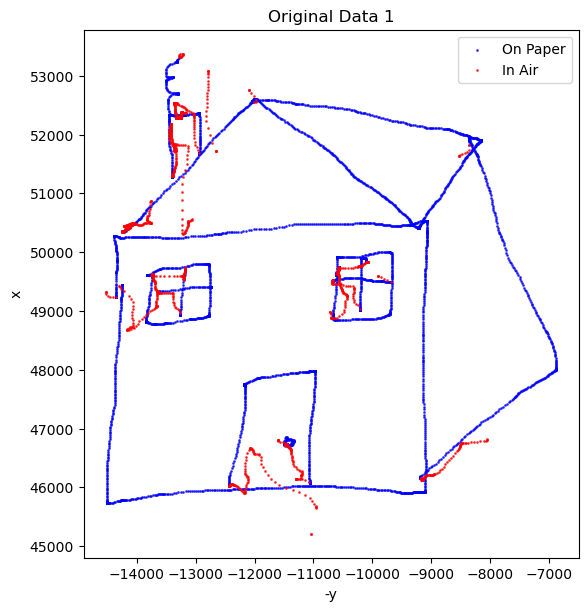

Number of processed files: 1
Average number of data points: 5553


In [35]:
# Cell 2
# Updated function
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    # Create the folder if it doesn't exist
    output_folder = 'original_absolute'
    os.makedirs(output_folder, exist_ok=True)

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Save the modified data to the 'original_absolute' folder
        save_path = os.path.join(output_folder, filename)
        df.to_csv(save_path, sep=' ', index=False, header=False)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

directory = 'Task2'  # Directory where the .svc files are stored
num_files_to_use = 1
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [36]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 8].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 7

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 7

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)


    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [37]:

# Cell 4
processed_dataframes = []

for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)
    
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

    # print(f"Processed DataFrame for: {input_filename}")



In [39]:
# Cell 5 (modified)
def process_dataframes(dataframes, num_files_to_use=None):
    if num_files_to_use:
        dataframes = dataframes[:num_files_to_use]

    data_frames = []
    scalers = []

    for i, df in enumerate(dataframes):
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        data_frames.append(df)
        scaler = MinMaxScaler()
        scaler.fit(df[['x', 'y', 'timestamp']])  # Fit the scaler
        scalers.append(scaler)

        # Print the first few rows of the timestamp column
        # print(f"Modified timestamps for DataFrame {i + 1}:")
        # print(df['timestamp'].head())
        # print("\n")

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, [f"DataFrame_{i+1}" for i in range(len(dataframes))]

# Use the processed_dataframes directly 
data_frames, processed_data, scalers, avg_data_points, original_filenames = process_dataframes(processed_dataframes, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

Number of processed files: 1
Average number of data points: 5971


In [40]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, lambda_shift=0.01, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.beta = beta
        self.lambda_shift = lambda_shift
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        # Apply shift correction
        return eps * tf.exp(logvar * .5) + (mean + self.lambda_shift * tf.exp(logvar * .5))

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        config.pop('trainable', None)
        config.pop('dtype', None)
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta,
            'lambda_shift': self.lambda_shift
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 128
beta = 0.001
learning_rate = 0.001
lambda_shift = 0.5

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [41]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        original_data = data_frames[i % num_input_files]
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()

        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/100: 100%|██████████| 12/12 [00:17<00:00,  1.43s/batch, Generator Loss=0.012, Reconstruction Loss=0.00712, KL Loss=0.486] 


Epoch 1: Generator Loss = 0.014258, Reconstruction Loss = 0.009558, KL Divergence Loss = 0.470000


Epoch 2/100: 100%|██████████| 12/12 [00:00<00:00, 16.19batch/s, Generator Loss=0.00919, Reconstruction Loss=0.00463, KL Loss=0.457]


Epoch 2: Generator Loss = 0.010069, Reconstruction Loss = 0.005365, KL Divergence Loss = 0.470374


Epoch 3/100: 100%|██████████| 12/12 [00:01<00:00, 11.58batch/s, Generator Loss=0.00753, Reconstruction Loss=0.00297, KL Loss=0.457]


Epoch 3: Generator Loss = 0.008141, Reconstruction Loss = 0.003666, KL Divergence Loss = 0.447554


Epoch 4/100: 100%|██████████| 12/12 [00:00<00:00, 14.28batch/s, Generator Loss=0.00679, Reconstruction Loss=0.00265, KL Loss=0.414]


Epoch 4: Generator Loss = 0.007183, Reconstruction Loss = 0.002916, KL Divergence Loss = 0.426731


Epoch 5/100: 100%|██████████| 12/12 [00:00<00:00, 25.77batch/s, Generator Loss=0.00652, Reconstruction Loss=0.00261, KL Loss=0.39] 


Epoch 5: Generator Loss = 0.006715, Reconstruction Loss = 0.002722, KL Divergence Loss = 0.399303


Epoch 6/100: 100%|██████████| 12/12 [00:01<00:00, 11.65batch/s, Generator Loss=0.00636, Reconstruction Loss=0.00248, KL Loss=0.388]


Epoch 6: Generator Loss = 0.006371, Reconstruction Loss = 0.002573, KL Divergence Loss = 0.379799


Epoch 7/100: 100%|██████████| 12/12 [00:00<00:00, 18.60batch/s, Generator Loss=0.00594, Reconstruction Loss=0.00242, KL Loss=0.352]


Epoch 7: Generator Loss = 0.006201, Reconstruction Loss = 0.002573, KL Divergence Loss = 0.362823


Epoch 8/100: 100%|██████████| 12/12 [00:00<00:00, 17.69batch/s, Generator Loss=0.00602, Reconstruction Loss=0.00258, KL Loss=0.344]


Epoch 8: Generator Loss = 0.006081, Reconstruction Loss = 0.002568, KL Divergence Loss = 0.351294


Epoch 9/100: 100%|██████████| 12/12 [00:01<00:00, 10.60batch/s, Generator Loss=0.00583, Reconstruction Loss=0.00246, KL Loss=0.337]


Epoch 9: Generator Loss = 0.005916, Reconstruction Loss = 0.002492, KL Divergence Loss = 0.342442


Epoch 10/100: 100%|██████████| 12/12 [00:00<00:00, 19.96batch/s, Generator Loss=0.00564, Reconstruction Loss=0.00228, KL Loss=0.337]


Epoch 10: Generator Loss = 0.005846, Reconstruction Loss = 0.002493, KL Divergence Loss = 0.335282


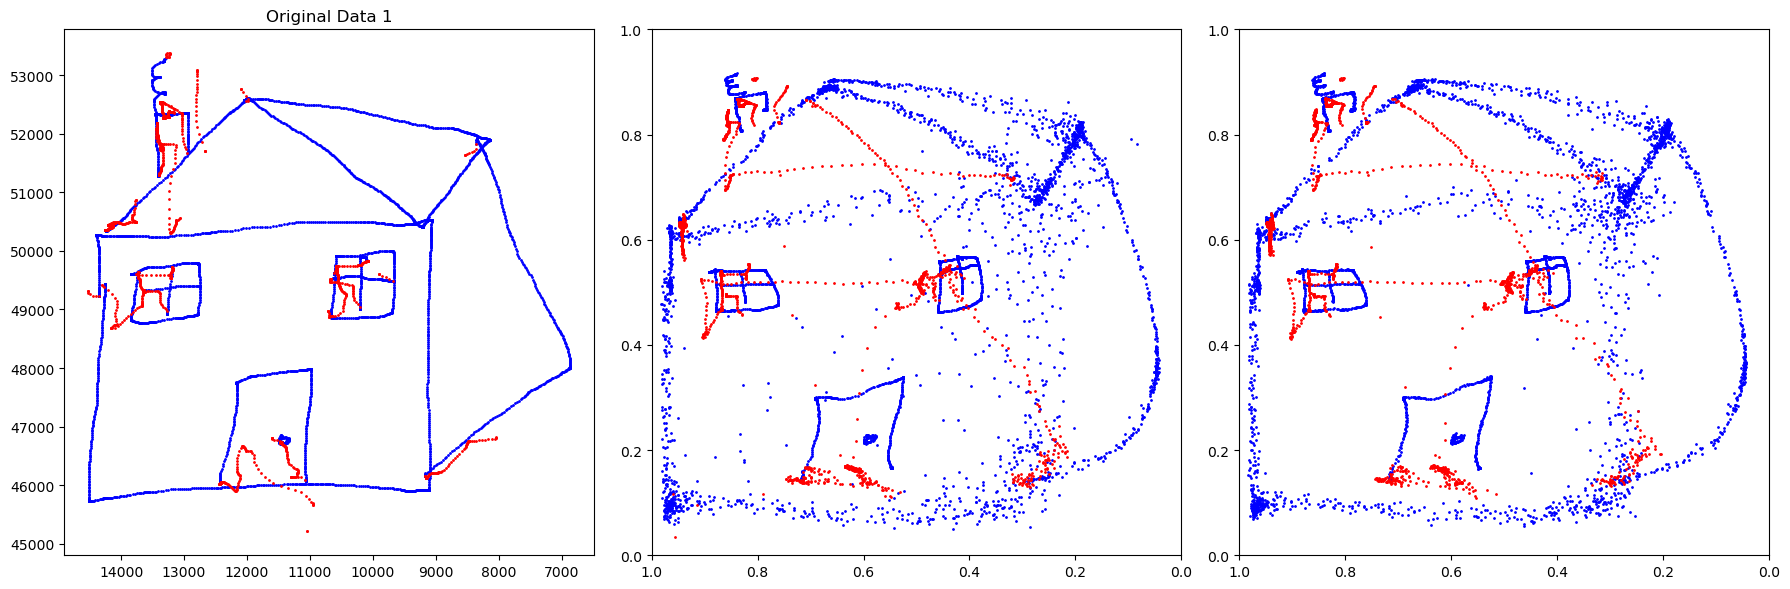

VAE model saved for epoch 10 at vae_models\epoch_10_model.h5.


Epoch 11/100: 100%|██████████| 12/12 [00:00<00:00, 17.14batch/s, Generator Loss=0.00609, Reconstruction Loss=0.00275, KL Loss=0.334]


Epoch 11: Generator Loss = 0.005773, Reconstruction Loss = 0.002464, KL Divergence Loss = 0.330893


Epoch 12/100: 100%|██████████| 12/12 [00:00<00:00, 22.43batch/s, Generator Loss=0.00558, Reconstruction Loss=0.00237, KL Loss=0.321]


Epoch 12: Generator Loss = 0.005629, Reconstruction Loss = 0.002367, KL Divergence Loss = 0.326166


Epoch 13/100: 100%|██████████| 12/12 [00:00<00:00, 15.63batch/s, Generator Loss=0.00551, Reconstruction Loss=0.00237, KL Loss=0.315]


Epoch 13: Generator Loss = 0.005576, Reconstruction Loss = 0.002364, KL Divergence Loss = 0.321129


Epoch 14/100: 100%|██████████| 12/12 [00:00<00:00, 13.33batch/s, Generator Loss=0.00555, Reconstruction Loss=0.00241, KL Loss=0.314]


Epoch 14: Generator Loss = 0.005482, Reconstruction Loss = 0.002328, KL Divergence Loss = 0.315328


Epoch 15/100: 100%|██████████| 12/12 [00:00<00:00, 21.08batch/s, Generator Loss=0.00561, Reconstruction Loss=0.00245, KL Loss=0.315]


Epoch 15: Generator Loss = 0.005461, Reconstruction Loss = 0.002344, KL Divergence Loss = 0.311710


Epoch 16/100: 100%|██████████| 12/12 [00:00<00:00, 21.19batch/s, Generator Loss=0.00578, Reconstruction Loss=0.00277, KL Loss=0.301]


Epoch 16: Generator Loss = 0.005433, Reconstruction Loss = 0.002358, KL Divergence Loss = 0.307516


Epoch 17/100: 100%|██████████| 12/12 [00:01<00:00,  9.86batch/s, Generator Loss=0.00549, Reconstruction Loss=0.00242, KL Loss=0.306]


Epoch 17: Generator Loss = 0.005415, Reconstruction Loss = 0.002362, KL Divergence Loss = 0.305237


Epoch 18/100: 100%|██████████| 12/12 [00:00<00:00, 20.02batch/s, Generator Loss=0.00546, Reconstruction Loss=0.00236, KL Loss=0.31] 


Epoch 18: Generator Loss = 0.005283, Reconstruction Loss = 0.002237, KL Divergence Loss = 0.304553


Epoch 19/100: 100%|██████████| 12/12 [00:00<00:00, 22.13batch/s, Generator Loss=0.00533, Reconstruction Loss=0.00231, KL Loss=0.302]


Epoch 19: Generator Loss = 0.005282, Reconstruction Loss = 0.002248, KL Divergence Loss = 0.303376


Epoch 20/100: 100%|██████████| 12/12 [00:00<00:00, 15.18batch/s, Generator Loss=0.00521, Reconstruction Loss=0.00223, KL Loss=0.298]


Epoch 20: Generator Loss = 0.005260, Reconstruction Loss = 0.002244, KL Divergence Loss = 0.301570


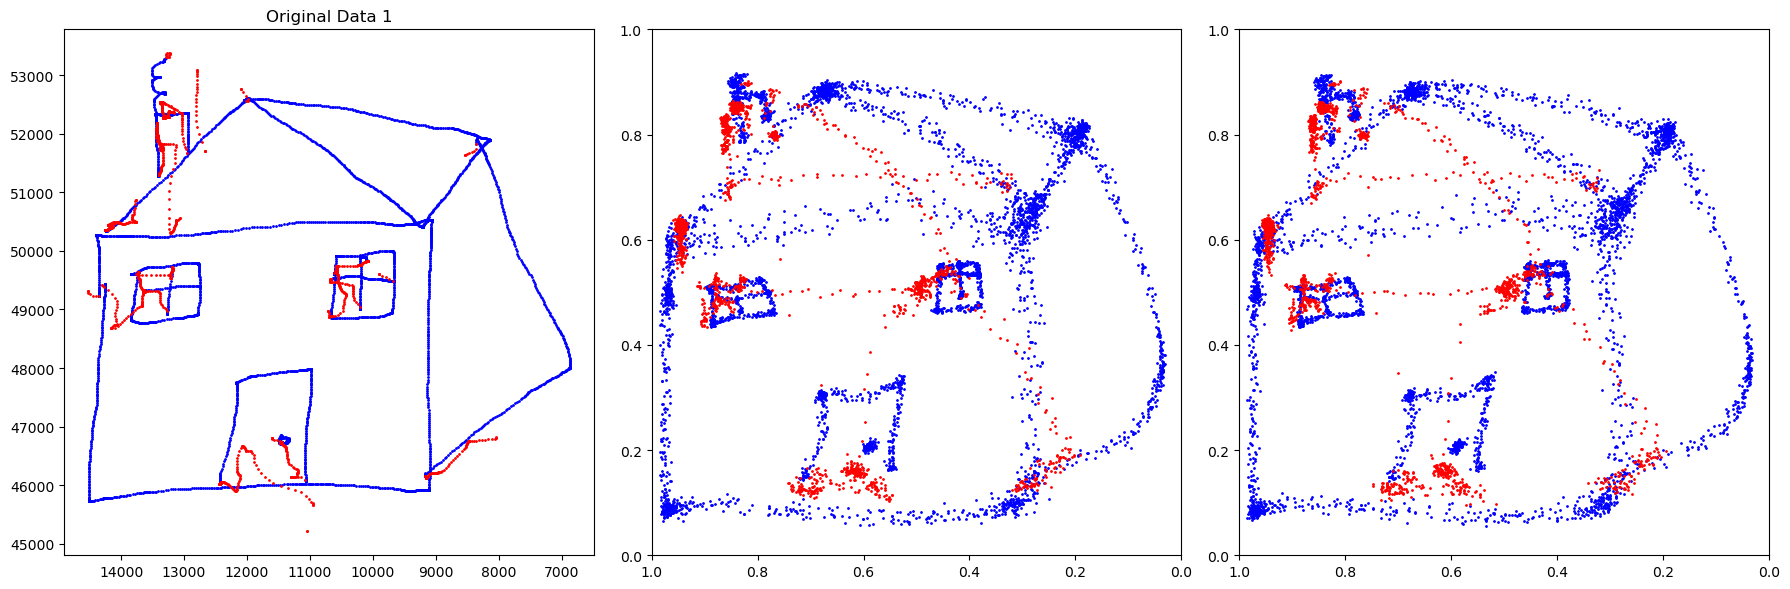

VAE model saved for epoch 20 at vae_models\epoch_20_model.h5.


Epoch 21/100: 100%|██████████| 12/12 [00:00<00:00, 15.53batch/s, Generator Loss=0.00501, Reconstruction Loss=0.00211, KL Loss=0.29] 


Epoch 21: Generator Loss = 0.005114, Reconstruction Loss = 0.002135, KL Divergence Loss = 0.297848


Epoch 22/100: 100%|██████████| 12/12 [00:00<00:00, 20.61batch/s, Generator Loss=0.00503, Reconstruction Loss=0.002, KL Loss=0.304]  


Epoch 22: Generator Loss = 0.005171, Reconstruction Loss = 0.002218, KL Divergence Loss = 0.295294


Epoch 23/100: 100%|██████████| 12/12 [00:00<00:00, 30.80batch/s, Generator Loss=0.00533, Reconstruction Loss=0.00238, KL Loss=0.295]


Epoch 23: Generator Loss = 0.005181, Reconstruction Loss = 0.002233, KL Divergence Loss = 0.294776


Epoch 24/100: 100%|██████████| 12/12 [00:00<00:00, 21.08batch/s, Generator Loss=0.00494, Reconstruction Loss=0.00198, KL Loss=0.296]


Epoch 24: Generator Loss = 0.005094, Reconstruction Loss = 0.002149, KL Divergence Loss = 0.294539


Epoch 25/100: 100%|██████████| 12/12 [00:00<00:00, 28.50batch/s, Generator Loss=0.00518, Reconstruction Loss=0.00224, KL Loss=0.294]


Epoch 25: Generator Loss = 0.005091, Reconstruction Loss = 0.002147, KL Divergence Loss = 0.294391


Epoch 26/100: 100%|██████████| 12/12 [00:01<00:00, 11.66batch/s, Generator Loss=0.00494, Reconstruction Loss=0.00205, KL Loss=0.289]


Epoch 26: Generator Loss = 0.005032, Reconstruction Loss = 0.002111, KL Divergence Loss = 0.292165


Epoch 27/100: 100%|██████████| 12/12 [00:00<00:00, 17.21batch/s, Generator Loss=0.00494, Reconstruction Loss=0.00202, KL Loss=0.291]


Epoch 27: Generator Loss = 0.004982, Reconstruction Loss = 0.002076, KL Divergence Loss = 0.290646


Epoch 28/100: 100%|██████████| 12/12 [00:00<00:00, 14.92batch/s, Generator Loss=0.00503, Reconstruction Loss=0.00206, KL Loss=0.297]


Epoch 28: Generator Loss = 0.005047, Reconstruction Loss = 0.002130, KL Divergence Loss = 0.291722


Epoch 29/100: 100%|██████████| 12/12 [00:00<00:00, 13.02batch/s, Generator Loss=0.00501, Reconstruction Loss=0.00216, KL Loss=0.285]


Epoch 29: Generator Loss = 0.004937, Reconstruction Loss = 0.002013, KL Divergence Loss = 0.292355


Epoch 30/100: 100%|██████████| 12/12 [00:00<00:00, 26.97batch/s, Generator Loss=0.0052, Reconstruction Loss=0.00229, KL Loss=0.291] 


Epoch 30: Generator Loss = 0.004942, Reconstruction Loss = 0.002071, KL Divergence Loss = 0.287130


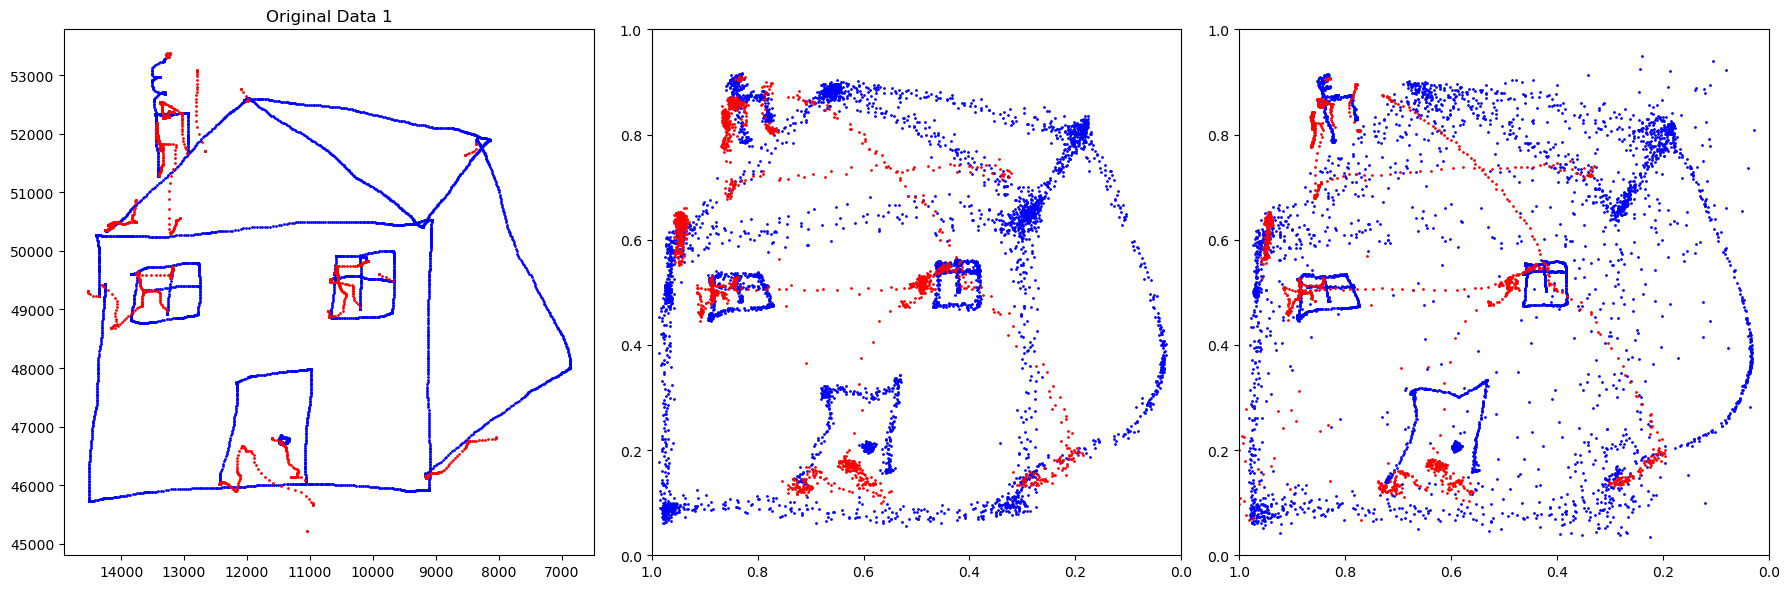

VAE model saved for epoch 30 at vae_models\epoch_30_model.h5.


Epoch 31/100: 100%|██████████| 12/12 [00:00<00:00, 24.79batch/s, Generator Loss=0.00487, Reconstruction Loss=0.00193, KL Loss=0.294]


Epoch 31: Generator Loss = 0.004896, Reconstruction Loss = 0.002033, KL Divergence Loss = 0.286215


Epoch 32/100: 100%|██████████| 12/12 [00:00<00:00, 25.60batch/s, Generator Loss=0.00479, Reconstruction Loss=0.00199, KL Loss=0.279]


Epoch 32: Generator Loss = 0.004893, Reconstruction Loss = 0.002057, KL Divergence Loss = 0.283559


Epoch 33/100: 100%|██████████| 12/12 [00:00<00:00, 34.40batch/s, Generator Loss=0.00492, Reconstruction Loss=0.00213, KL Loss=0.28] 


Epoch 33: Generator Loss = 0.004898, Reconstruction Loss = 0.002057, KL Divergence Loss = 0.284043


Epoch 34/100: 100%|██████████| 12/12 [00:00<00:00, 18.62batch/s, Generator Loss=0.00612, Reconstruction Loss=0.00333, KL Loss=0.279]


Epoch 34: Generator Loss = 0.004939, Reconstruction Loss = 0.002118, KL Divergence Loss = 0.282122


Epoch 35/100: 100%|██████████| 12/12 [00:01<00:00,  8.80batch/s, Generator Loss=0.00481, Reconstruction Loss=0.0018, KL Loss=0.301] 


Epoch 35: Generator Loss = 0.005053, Reconstruction Loss = 0.002097, KL Divergence Loss = 0.295594


Epoch 36/100: 100%|██████████| 12/12 [00:00<00:00, 16.19batch/s, Generator Loss=0.00496, Reconstruction Loss=0.00195, KL Loss=0.301]


Epoch 36: Generator Loss = 0.004901, Reconstruction Loss = 0.001857, KL Divergence Loss = 0.304332


Epoch 37/100: 100%|██████████| 12/12 [00:00<00:00, 13.53batch/s, Generator Loss=0.00487, Reconstruction Loss=0.00197, KL Loss=0.29] 


Epoch 37: Generator Loss = 0.004848, Reconstruction Loss = 0.001875, KL Divergence Loss = 0.297282


Epoch 38/100: 100%|██████████| 12/12 [00:00<00:00, 16.45batch/s, Generator Loss=0.00474, Reconstruction Loss=0.00193, KL Loss=0.282]


Epoch 38: Generator Loss = 0.004820, Reconstruction Loss = 0.001951, KL Divergence Loss = 0.286867


Epoch 39/100: 100%|██████████| 12/12 [00:00<00:00, 15.12batch/s, Generator Loss=0.0047, Reconstruction Loss=0.00197, KL Loss=0.273] 


Epoch 39: Generator Loss = 0.004763, Reconstruction Loss = 0.001962, KL Divergence Loss = 0.280103


Epoch 40/100: 100%|██████████| 12/12 [00:01<00:00, 11.15batch/s, Generator Loss=0.00455, Reconstruction Loss=0.0018, KL Loss=0.275] 


Epoch 40: Generator Loss = 0.004738, Reconstruction Loss = 0.001964, KL Divergence Loss = 0.277390


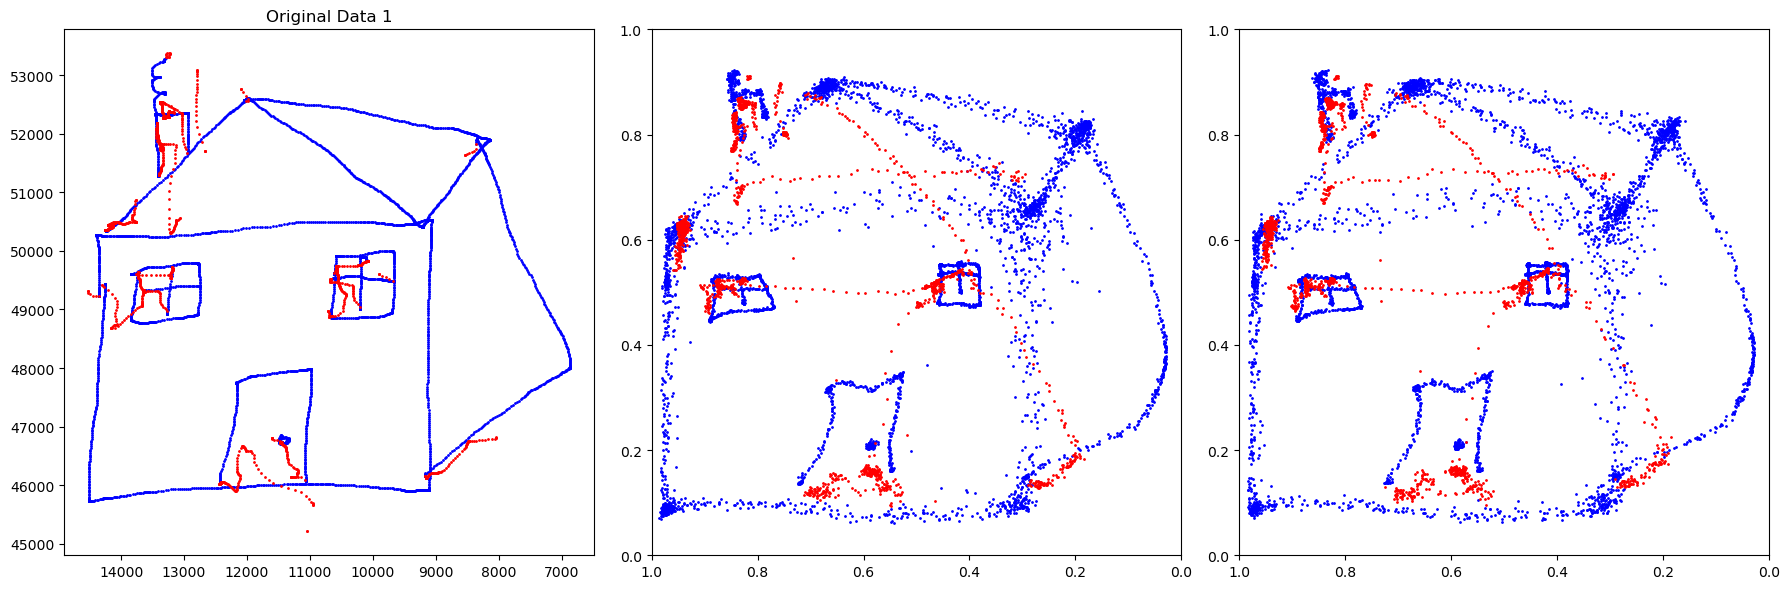

VAE model saved for epoch 40 at vae_models\epoch_40_model.h5.


Epoch 41/100: 100%|██████████| 12/12 [00:00<00:00, 21.69batch/s, Generator Loss=0.00463, Reconstruction Loss=0.00188, KL Loss=0.275]


Epoch 41: Generator Loss = 0.004708, Reconstruction Loss = 0.001953, KL Divergence Loss = 0.275525


Epoch 42/100: 100%|██████████| 12/12 [00:00<00:00, 19.75batch/s, Generator Loss=0.00474, Reconstruction Loss=0.00191, KL Loss=0.283]


Epoch 42: Generator Loss = 0.004914, Reconstruction Loss = 0.002122, KL Divergence Loss = 0.279155


Epoch 43/100: 100%|██████████| 12/12 [00:00<00:00, 13.40batch/s, Generator Loss=0.0052, Reconstruction Loss=0.00232, KL Loss=0.288] 


Epoch 43: Generator Loss = 0.004807, Reconstruction Loss = 0.001947, KL Divergence Loss = 0.285971


Epoch 44/100: 100%|██████████| 12/12 [00:00<00:00, 12.79batch/s, Generator Loss=0.00457, Reconstruction Loss=0.00178, KL Loss=0.279]


Epoch 44: Generator Loss = 0.004718, Reconstruction Loss = 0.001868, KL Divergence Loss = 0.284996


Epoch 45/100: 100%|██████████| 12/12 [00:00<00:00, 16.04batch/s, Generator Loss=0.0046, Reconstruction Loss=0.00184, KL Loss=0.275] 


Epoch 45: Generator Loss = 0.004641, Reconstruction Loss = 0.001872, KL Divergence Loss = 0.276976


Epoch 46/100: 100%|██████████| 12/12 [00:00<00:00, 12.11batch/s, Generator Loss=0.00464, Reconstruction Loss=0.00185, KL Loss=0.279]


Epoch 46: Generator Loss = 0.004640, Reconstruction Loss = 0.001877, KL Divergence Loss = 0.276306


Epoch 47/100: 100%|██████████| 12/12 [00:00<00:00, 16.57batch/s, Generator Loss=0.00463, Reconstruction Loss=0.00187, KL Loss=0.275]


Epoch 47: Generator Loss = 0.004600, Reconstruction Loss = 0.001837, KL Divergence Loss = 0.276331


Epoch 48/100: 100%|██████████| 12/12 [00:00<00:00, 16.62batch/s, Generator Loss=0.00447, Reconstruction Loss=0.00174, KL Loss=0.273]


Epoch 48: Generator Loss = 0.004608, Reconstruction Loss = 0.001876, KL Divergence Loss = 0.273263


Epoch 49/100: 100%|██████████| 12/12 [00:00<00:00, 14.92batch/s, Generator Loss=0.00441, Reconstruction Loss=0.00168, KL Loss=0.273]


Epoch 49: Generator Loss = 0.004528, Reconstruction Loss = 0.001813, KL Divergence Loss = 0.271518


Epoch 50/100: 100%|██████████| 12/12 [00:01<00:00, 11.31batch/s, Generator Loss=0.00436, Reconstruction Loss=0.00168, KL Loss=0.268]


Epoch 50: Generator Loss = 0.004494, Reconstruction Loss = 0.001813, KL Divergence Loss = 0.268117


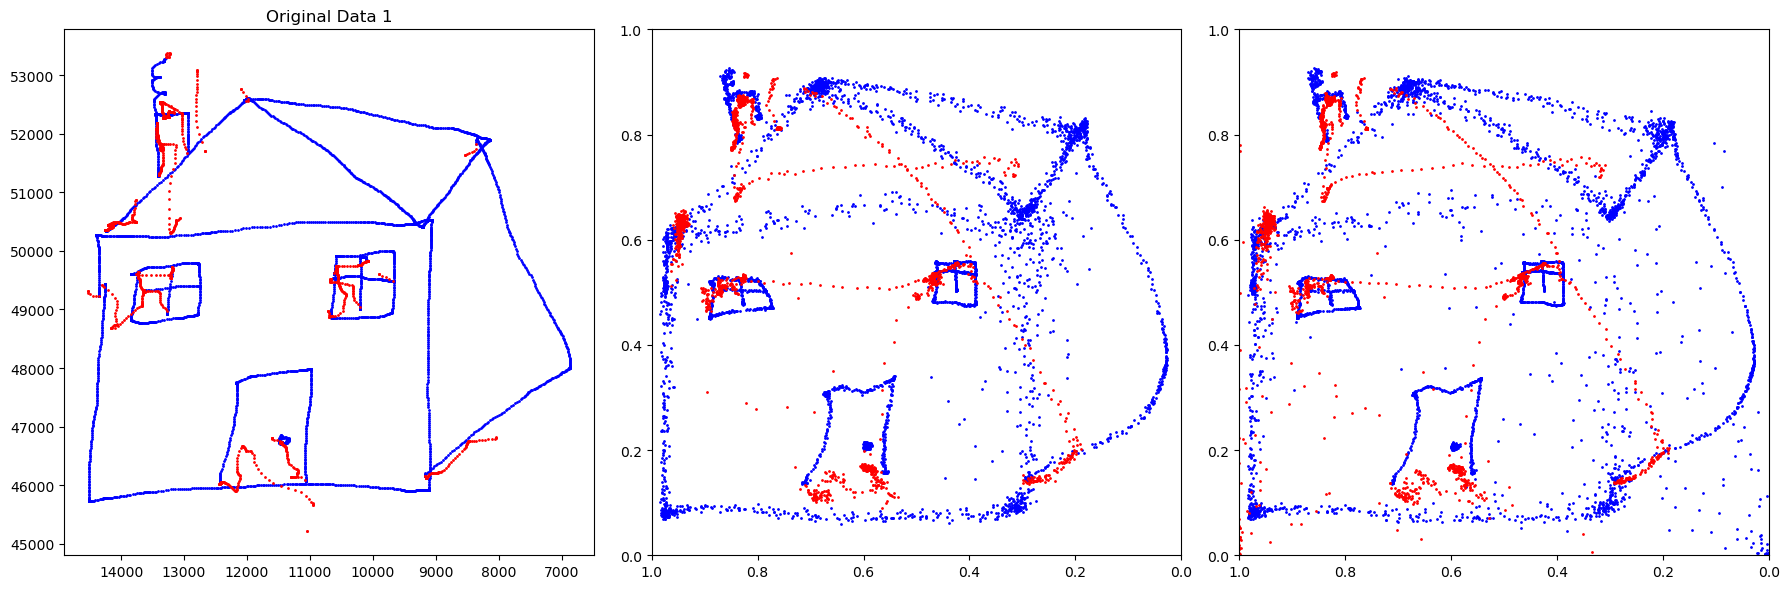

VAE model saved for epoch 50 at vae_models\epoch_50_model.h5.


Epoch 51/100: 100%|██████████| 12/12 [00:00<00:00, 23.68batch/s, Generator Loss=0.00462, Reconstruction Loss=0.00199, KL Loss=0.264]


Epoch 51: Generator Loss = 0.004521, Reconstruction Loss = 0.001849, KL Divergence Loss = 0.267185


Epoch 52/100: 100%|██████████| 12/12 [00:00<00:00, 17.68batch/s, Generator Loss=0.00461, Reconstruction Loss=0.00194, KL Loss=0.267]


Epoch 52: Generator Loss = 0.004586, Reconstruction Loss = 0.001944, KL Divergence Loss = 0.264200


Epoch 53/100: 100%|██████████| 12/12 [00:00<00:00, 17.86batch/s, Generator Loss=0.00487, Reconstruction Loss=0.0021, KL Loss=0.277] 


Epoch 53: Generator Loss = 0.004723, Reconstruction Loss = 0.002029, KL Divergence Loss = 0.269368


Epoch 54/100: 100%|██████████| 12/12 [00:00<00:00, 14.73batch/s, Generator Loss=0.00442, Reconstruction Loss=0.00149, KL Loss=0.293]


Epoch 54: Generator Loss = 0.004755, Reconstruction Loss = 0.001881, KL Divergence Loss = 0.287451


Epoch 55/100: 100%|██████████| 12/12 [00:00<00:00, 19.33batch/s, Generator Loss=0.00468, Reconstruction Loss=0.00182, KL Loss=0.286]


Epoch 55: Generator Loss = 0.004630, Reconstruction Loss = 0.001736, KL Divergence Loss = 0.289333


Epoch 56/100: 100%|██████████| 12/12 [00:01<00:00, 11.81batch/s, Generator Loss=0.00441, Reconstruction Loss=0.00163, KL Loss=0.278]


Epoch 56: Generator Loss = 0.004549, Reconstruction Loss = 0.001752, KL Divergence Loss = 0.279750


Epoch 57/100: 100%|██████████| 12/12 [00:00<00:00, 18.04batch/s, Generator Loss=0.00446, Reconstruction Loss=0.00186, KL Loss=0.26]


Epoch 57: Generator Loss = 0.004474, Reconstruction Loss = 0.001765, KL Divergence Loss = 0.270922


Epoch 58/100: 100%|██████████| 12/12 [00:00<00:00, 20.51batch/s, Generator Loss=0.0045, Reconstruction Loss=0.00188, KL Loss=0.263]


Epoch 58: Generator Loss = 0.004507, Reconstruction Loss = 0.001864, KL Divergence Loss = 0.264312


Epoch 59/100: 100%|██████████| 12/12 [00:01<00:00, 11.76batch/s, Generator Loss=0.00437, Reconstruction Loss=0.00184, KL Loss=0.253]


Epoch 59: Generator Loss = 0.004399, Reconstruction Loss = 0.001788, KL Divergence Loss = 0.261104


Epoch 60/100: 100%|██████████| 12/12 [00:00<00:00, 22.50batch/s, Generator Loss=0.00463, Reconstruction Loss=0.00211, KL Loss=0.252]


Epoch 60: Generator Loss = 0.004404, Reconstruction Loss = 0.001815, KL Divergence Loss = 0.258881


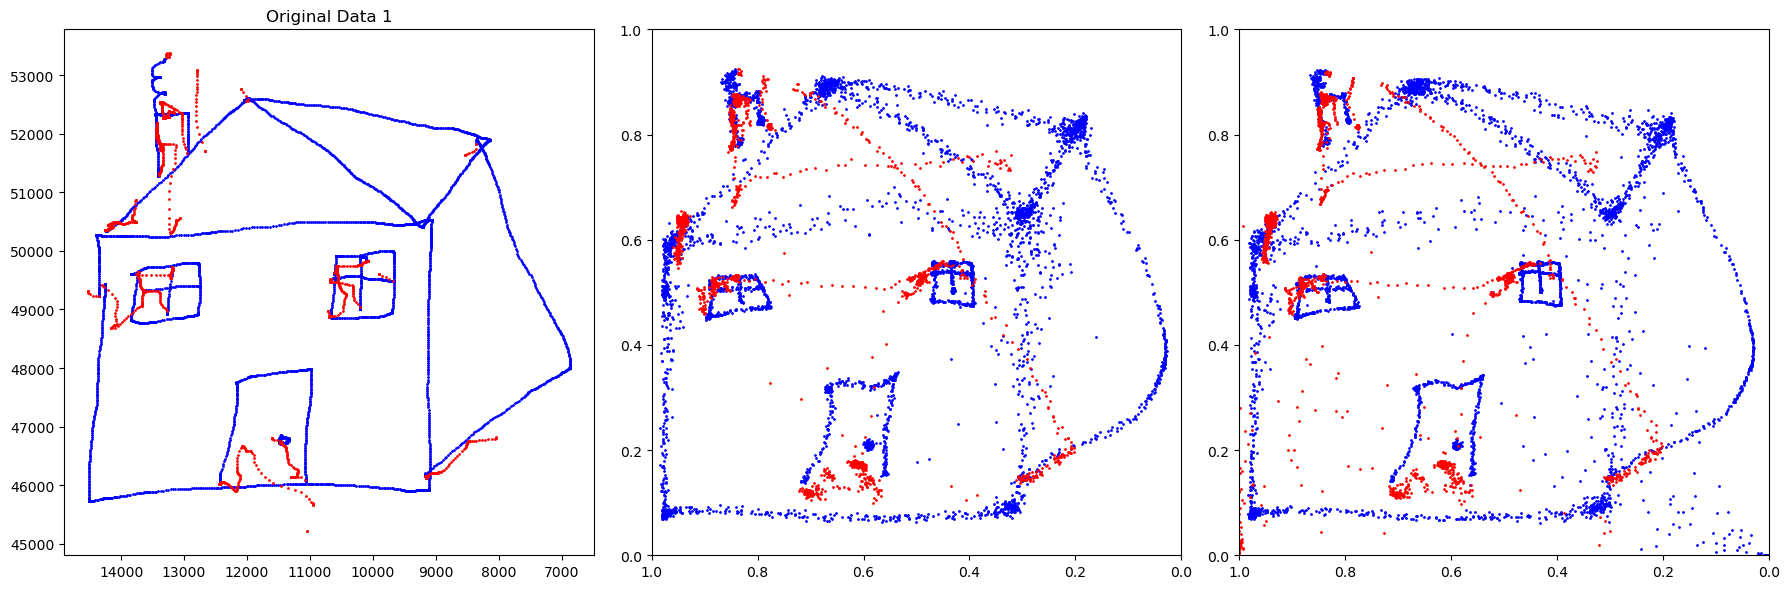

VAE model saved for epoch 60 at vae_models\epoch_60_model.h5.


Epoch 61/100: 100%|██████████| 12/12 [00:00<00:00, 22.53batch/s, Generator Loss=0.00445, Reconstruction Loss=0.00189, KL Loss=0.256]


Epoch 61: Generator Loss = 0.004370, Reconstruction Loss = 0.001779, KL Divergence Loss = 0.259075


Epoch 62/100: 100%|██████████| 12/12 [00:00<00:00, 18.23batch/s, Generator Loss=0.00418, Reconstruction Loss=0.00161, KL Loss=0.258]


Epoch 62: Generator Loss = 0.004323, Reconstruction Loss = 0.001729, KL Divergence Loss = 0.259422


Epoch 63/100: 100%|██████████| 12/12 [00:01<00:00,  8.99batch/s, Generator Loss=0.00443, Reconstruction Loss=0.00187, KL Loss=0.256]


Epoch 63: Generator Loss = 0.004342, Reconstruction Loss = 0.001765, KL Divergence Loss = 0.257629


Epoch 64/100: 100%|██████████| 12/12 [00:00<00:00, 24.38batch/s, Generator Loss=0.00425, Reconstruction Loss=0.00169, KL Loss=0.255]


Epoch 64: Generator Loss = 0.004305, Reconstruction Loss = 0.001742, KL Divergence Loss = 0.256285


Epoch 65/100: 100%|██████████| 12/12 [00:00<00:00, 13.50batch/s, Generator Loss=0.00465, Reconstruction Loss=0.0021, KL Loss=0.256] 


Epoch 65: Generator Loss = 0.004264, Reconstruction Loss = 0.001701, KL Divergence Loss = 0.256344


Epoch 66/100: 100%|██████████| 12/12 [00:00<00:00, 17.37batch/s, Generator Loss=0.00443, Reconstruction Loss=0.00185, KL Loss=0.258]


Epoch 66: Generator Loss = 0.004323, Reconstruction Loss = 0.001778, KL Divergence Loss = 0.254465


Epoch 67/100: 100%|██████████| 12/12 [00:00<00:00, 26.30batch/s, Generator Loss=0.00432, Reconstruction Loss=0.00164, KL Loss=0.268]


Epoch 67: Generator Loss = 0.004378, Reconstruction Loss = 0.001776, KL Divergence Loss = 0.260239


Epoch 68/100: 100%|██████████| 12/12 [00:00<00:00, 13.41batch/s, Generator Loss=0.00433, Reconstruction Loss=0.00165, KL Loss=0.268]


Epoch 68: Generator Loss = 0.004309, Reconstruction Loss = 0.001626, KL Divergence Loss = 0.268304


Epoch 69/100: 100%|██████████| 12/12 [00:00<00:00, 17.13batch/s, Generator Loss=0.0044, Reconstruction Loss=0.00183, KL Loss=0.258] 


Epoch 69: Generator Loss = 0.004294, Reconstruction Loss = 0.001670, KL Divergence Loss = 0.262425


Epoch 70/100: 100%|██████████| 12/12 [00:00<00:00, 23.64batch/s, Generator Loss=0.00828, Reconstruction Loss=0.00559, KL Loss=0.268]


Epoch 70: Generator Loss = 0.004687, Reconstruction Loss = 0.002051, KL Divergence Loss = 0.263557


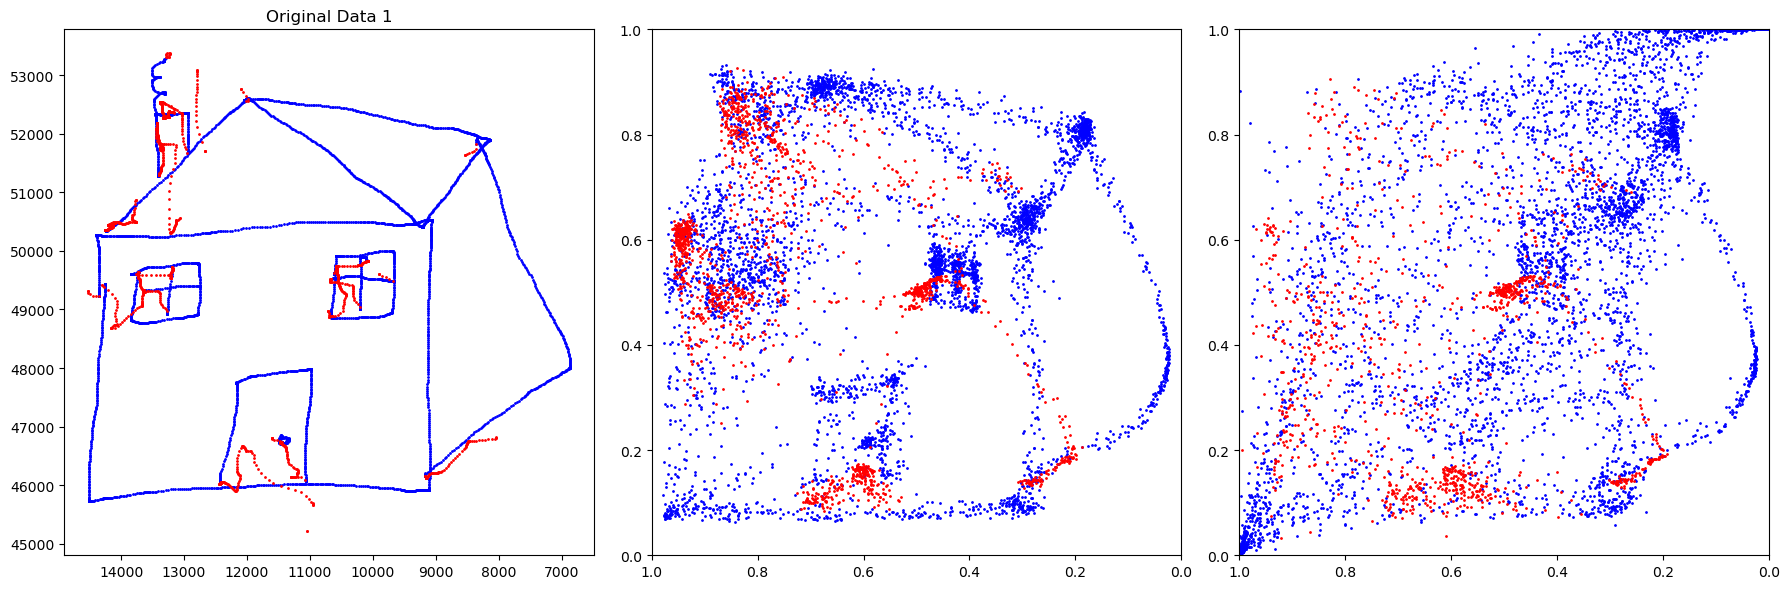

VAE model saved for epoch 70 at vae_models\epoch_70_model.h5.


Epoch 71/100: 100%|██████████| 12/12 [00:00<00:00, 15.71batch/s, Generator Loss=0.00521, Reconstruction Loss=0.00198, KL Loss=0.323]


Epoch 71: Generator Loss = 0.005285, Reconstruction Loss = 0.002367, KL Divergence Loss = 0.291736


Epoch 72/100: 100%|██████████| 12/12 [00:01<00:00, 10.68batch/s, Generator Loss=0.00467, Reconstruction Loss=0.0016, KL Loss=0.307] 


Epoch 72: Generator Loss = 0.004955, Reconstruction Loss = 0.001797, KL Divergence Loss = 0.315734


Epoch 73/100: 100%|██████████| 12/12 [00:00<00:00, 14.92batch/s, Generator Loss=0.00456, Reconstruction Loss=0.00167, KL Loss=0.289]


Epoch 73: Generator Loss = 0.004668, Reconstruction Loss = 0.001652, KL Divergence Loss = 0.301646


Epoch 74/100: 100%|██████████| 12/12 [00:01<00:00,  8.88batch/s, Generator Loss=0.00438, Reconstruction Loss=0.00167, KL Loss=0.271]


Epoch 74: Generator Loss = 0.004488, Reconstruction Loss = 0.001675, KL Divergence Loss = 0.281258


Epoch 75/100: 100%|██████████| 12/12 [00:00<00:00, 17.41batch/s, Generator Loss=0.00412, Reconstruction Loss=0.00152, KL Loss=0.259]


Epoch 75: Generator Loss = 0.004317, Reconstruction Loss = 0.001657, KL Divergence Loss = 0.265969


Epoch 76/100: 100%|██████████| 12/12 [00:00<00:00, 14.56batch/s, Generator Loss=0.00432, Reconstruction Loss=0.00175, KL Loss=0.257]


Epoch 76: Generator Loss = 0.004294, Reconstruction Loss = 0.001715, KL Divergence Loss = 0.257856


Epoch 77/100: 100%|██████████| 12/12 [00:00<00:00, 17.00batch/s, Generator Loss=0.00436, Reconstruction Loss=0.00189, KL Loss=0.247]


Epoch 77: Generator Loss = 0.004215, Reconstruction Loss = 0.001690, KL Divergence Loss = 0.252550


Epoch 78/100: 100%|██████████| 12/12 [00:00<00:00, 12.24batch/s, Generator Loss=0.00411, Reconstruction Loss=0.0017, KL Loss=0.241] 


Epoch 78: Generator Loss = 0.004172, Reconstruction Loss = 0.001674, KL Divergence Loss = 0.249851


Epoch 79/100: 100%|██████████| 12/12 [00:00<00:00, 22.09batch/s, Generator Loss=0.00409, Reconstruction Loss=0.00162, KL Loss=0.247]


Epoch 79: Generator Loss = 0.004129, Reconstruction Loss = 0.001641, KL Divergence Loss = 0.248829


Epoch 80/100: 100%|██████████| 12/12 [00:00<00:00, 17.38batch/s, Generator Loss=0.00411, Reconstruction Loss=0.00167, KL Loss=0.244]


Epoch 80: Generator Loss = 0.004155, Reconstruction Loss = 0.001695, KL Divergence Loss = 0.246060


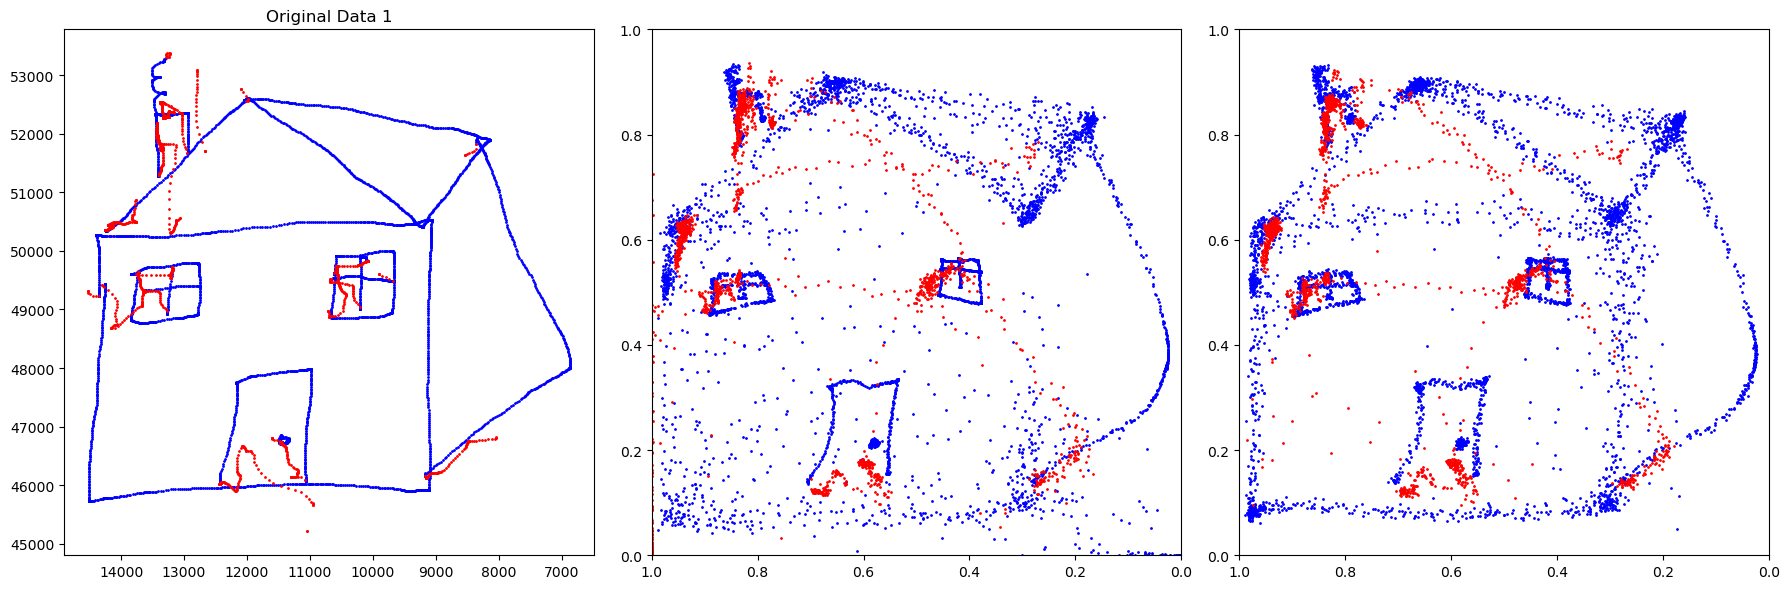

VAE model saved for epoch 80 at vae_models\epoch_80_model.h5.


Epoch 81/100: 100%|██████████| 12/12 [00:00<00:00, 18.74batch/s, Generator Loss=0.00392, Reconstruction Loss=0.00141, KL Loss=0.251]


Epoch 81: Generator Loss = 0.004055, Reconstruction Loss = 0.001591, KL Divergence Loss = 0.246401


Epoch 82/100: 100%|██████████| 12/12 [00:00<00:00, 17.92batch/s, Generator Loss=0.00414, Reconstruction Loss=0.00163, KL Loss=0.251]


Epoch 82: Generator Loss = 0.004157, Reconstruction Loss = 0.001681, KL Divergence Loss = 0.247656


Epoch 83/100: 100%|██████████| 12/12 [00:01<00:00, 11.10batch/s, Generator Loss=0.00404, Reconstruction Loss=0.00157, KL Loss=0.247]


Epoch 83: Generator Loss = 0.004036, Reconstruction Loss = 0.001551, KL Divergence Loss = 0.248529


Epoch 84/100: 100%|██████████| 12/12 [00:01<00:00,  8.67batch/s, Generator Loss=0.00391, Reconstruction Loss=0.00138, KL Loss=0.253]


Epoch 84: Generator Loss = 0.004157, Reconstruction Loss = 0.001690, KL Divergence Loss = 0.246694


Epoch 85/100: 100%|██████████| 12/12 [00:01<00:00, 10.31batch/s, Generator Loss=0.00397, Reconstruction Loss=0.00152, KL Loss=0.245]


Epoch 85: Generator Loss = 0.004008, Reconstruction Loss = 0.001522, KL Divergence Loss = 0.248657


Epoch 86/100: 100%|██████████| 12/12 [00:00<00:00, 16.72batch/s, Generator Loss=0.00395, Reconstruction Loss=0.0015, KL Loss=0.245] 


Epoch 86: Generator Loss = 0.003982, Reconstruction Loss = 0.001512, KL Divergence Loss = 0.246947


Epoch 87/100: 100%|██████████| 12/12 [00:00<00:00, 13.42batch/s, Generator Loss=0.0039, Reconstruction Loss=0.0015, KL Loss=0.24]   


Epoch 87: Generator Loss = 0.003935, Reconstruction Loss = 0.001479, KL Divergence Loss = 0.245583


Epoch 88/100: 100%|██████████| 12/12 [00:00<00:00, 14.68batch/s, Generator Loss=0.004, Reconstruction Loss=0.00165, KL Loss=0.235]  


Epoch 88: Generator Loss = 0.003941, Reconstruction Loss = 0.001540, KL Divergence Loss = 0.240053


Epoch 89/100: 100%|██████████| 12/12 [00:00<00:00, 19.87batch/s, Generator Loss=0.00383, Reconstruction Loss=0.00144, KL Loss=0.238]


Epoch 89: Generator Loss = 0.003925, Reconstruction Loss = 0.001556, KL Divergence Loss = 0.236880


Epoch 90/100: 100%|██████████| 12/12 [00:01<00:00,  9.01batch/s, Generator Loss=0.0038, Reconstruction Loss=0.00146, KL Loss=0.234] 


Epoch 90: Generator Loss = 0.003914, Reconstruction Loss = 0.001530, KL Divergence Loss = 0.238328


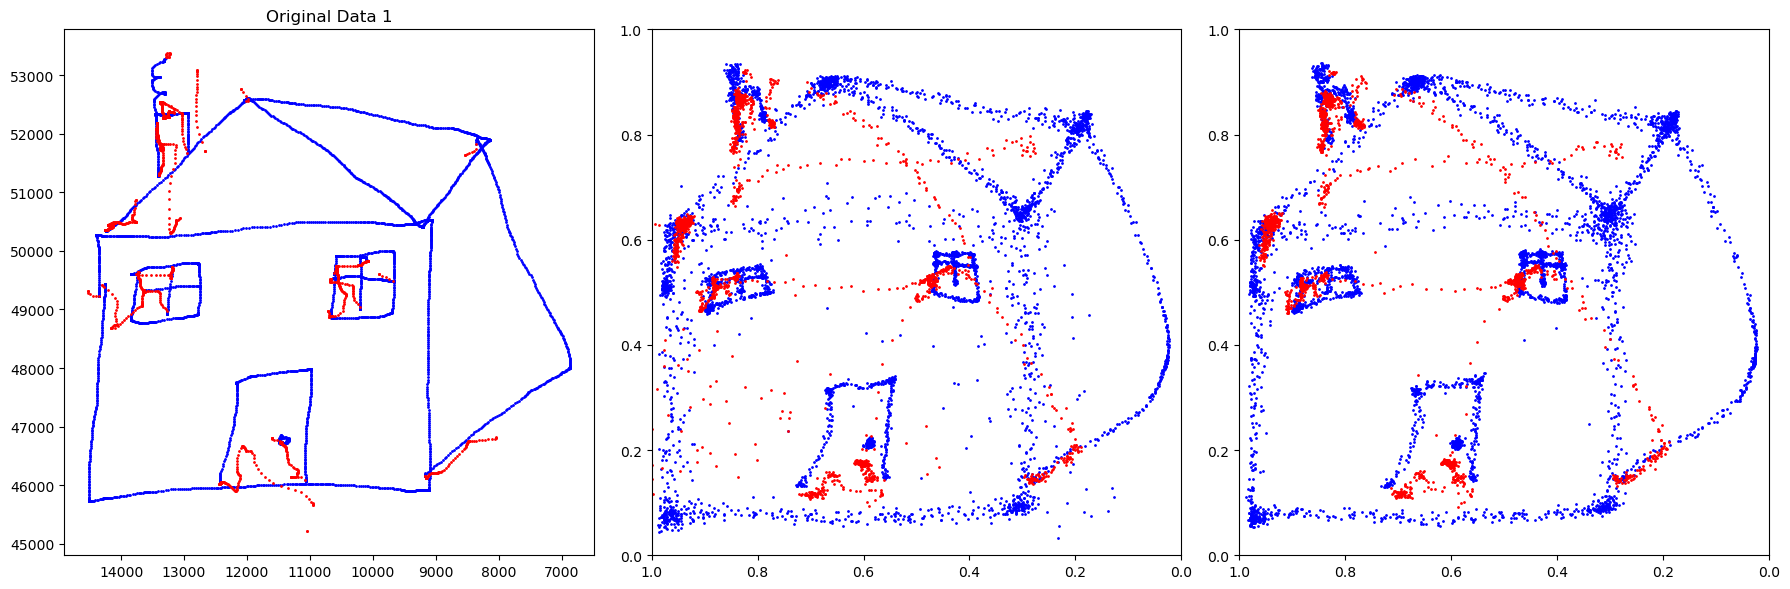

VAE model saved for epoch 90 at vae_models\epoch_90_model.h5.


Epoch 91/100: 100%|██████████| 12/12 [00:00<00:00, 21.11batch/s, Generator Loss=0.00394, Reconstruction Loss=0.00158, KL Loss=0.236]


Epoch 91: Generator Loss = 0.003928, Reconstruction Loss = 0.001556, KL Divergence Loss = 0.237165


Epoch 92/100: 100%|██████████| 12/12 [00:01<00:00, 10.35batch/s, Generator Loss=0.00377, Reconstruction Loss=0.00135, KL Loss=0.242]


Epoch 92: Generator Loss = 0.003871, Reconstruction Loss = 0.001463, KL Divergence Loss = 0.240781


Epoch 93/100: 100%|██████████| 12/12 [00:00<00:00, 18.40batch/s, Generator Loss=0.00388, Reconstruction Loss=0.00155, KL Loss=0.232]


Epoch 93: Generator Loss = 0.003792, Reconstruction Loss = 0.001406, KL Divergence Loss = 0.238683


Epoch 94/100: 100%|██████████| 12/12 [00:01<00:00, 10.61batch/s, Generator Loss=0.00373, Reconstruction Loss=0.00141, KL Loss=0.232]


Epoch 94: Generator Loss = 0.003760, Reconstruction Loss = 0.001437, KL Divergence Loss = 0.232305


Epoch 95/100: 100%|██████████| 12/12 [00:00<00:00, 16.43batch/s, Generator Loss=0.00381, Reconstruction Loss=0.0015, KL Loss=0.231] 


Epoch 95: Generator Loss = 0.003775, Reconstruction Loss = 0.001484, KL Divergence Loss = 0.229090


Epoch 96/100: 100%|██████████| 12/12 [00:00<00:00, 19.25batch/s, Generator Loss=0.00369, Reconstruction Loss=0.00139, KL Loss=0.23] 


Epoch 96: Generator Loss = 0.003770, Reconstruction Loss = 0.001476, KL Divergence Loss = 0.229433


Epoch 97/100: 100%|██████████| 12/12 [00:01<00:00,  8.73batch/s, Generator Loss=0.00372, Reconstruction Loss=0.00143, KL Loss=0.229]


Epoch 97: Generator Loss = 0.003747, Reconstruction Loss = 0.001445, KL Divergence Loss = 0.230175


Epoch 98/100: 100%|██████████| 12/12 [00:00<00:00, 13.63batch/s, Generator Loss=0.00374, Reconstruction Loss=0.0015, KL Loss=0.224]


Epoch 98: Generator Loss = 0.003784, Reconstruction Loss = 0.001503, KL Divergence Loss = 0.228080


Epoch 99/100: 100%|██████████| 12/12 [00:00<00:00, 14.44batch/s, Generator Loss=0.00478, Reconstruction Loss=0.00174, KL Loss=0.304]


Epoch 99: Generator Loss = 0.005264, Reconstruction Loss = 0.002560, KL Divergence Loss = 0.270313


Epoch 100/100: 100%|██████████| 12/12 [00:00<00:00, 12.57batch/s, Generator Loss=0.00445, Reconstruction Loss=0.00154, KL Loss=0.291]


Epoch 100: Generator Loss = 0.004670, Reconstruction Loss = 0.001655, KL Divergence Loss = 0.301495


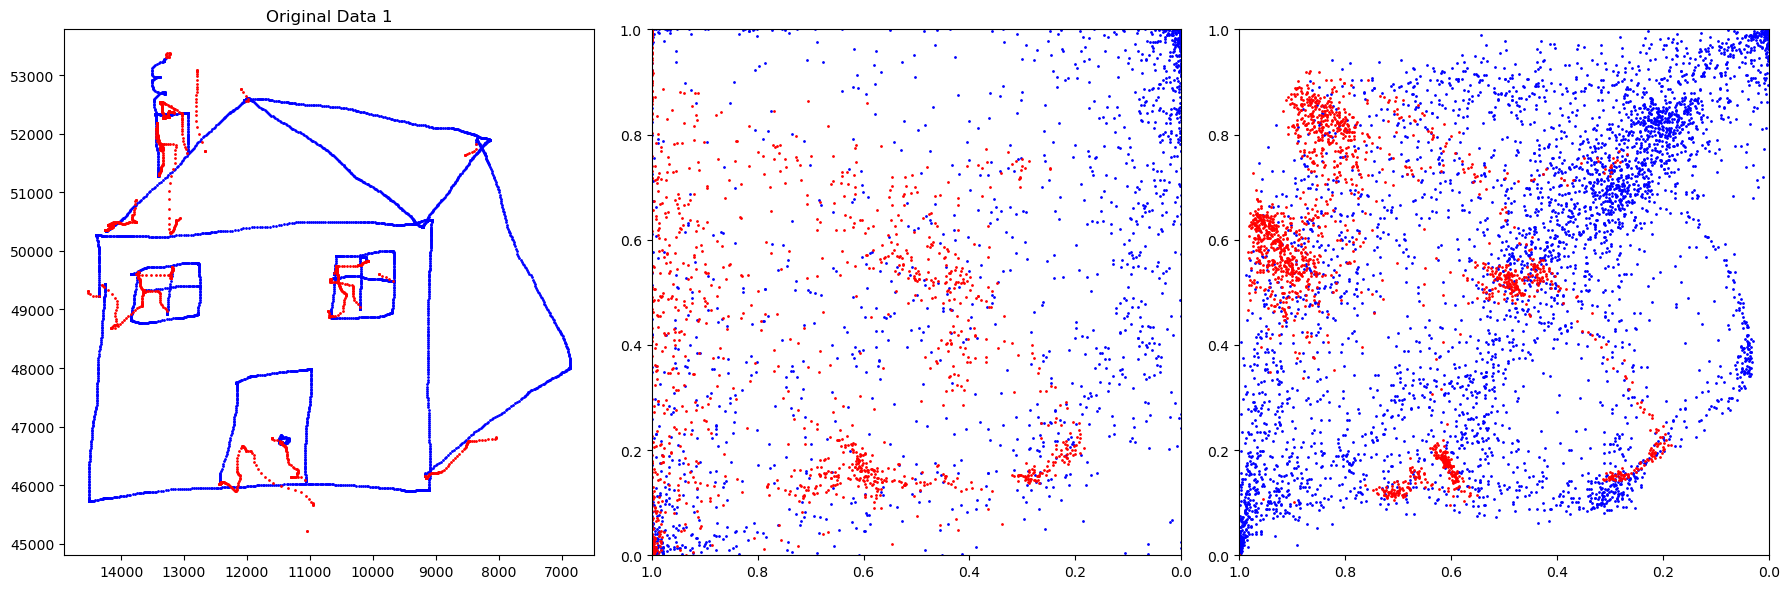

VAE model saved for epoch 100 at vae_models\epoch_100_model.h5.
Final VAE model saved.


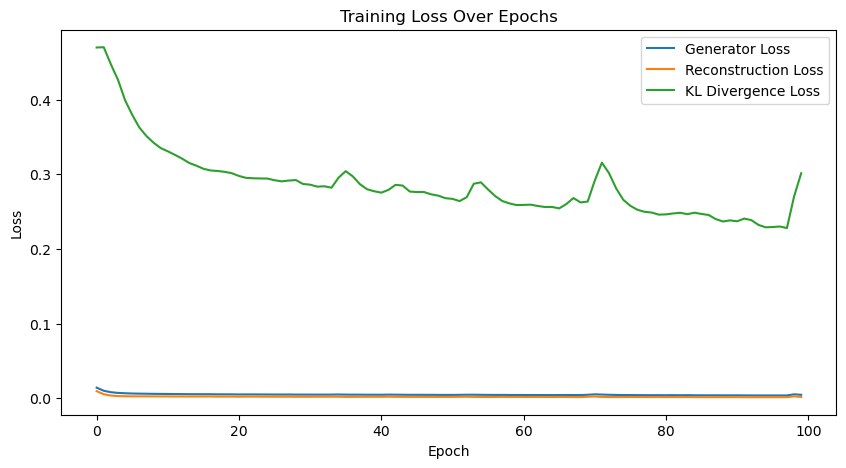

<Figure size 640x480 with 0 Axes>

In [34]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + model.beta * total_kl_loss + 0.1 * discriminator_loss
        else:
            generator_loss = reconstruction_loss + model.beta * total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 200
lstm_interval = 50
epochs = 100
visual_per_num_epoch = 10
num_augmented_files = 1

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

save_dir = "vae_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train LSTM every `lstm_interval` epochs after `vae_epochs`
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)
            generated_data = tf.expand_dims(augmented_data, axis=0)
            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')


    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)



    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")



    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)

        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        for i, original_data in enumerate(original_data_frames):
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]

            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].invert_xaxis()

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
            axs[i+len(original_data_frames)].invert_xaxis()
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)

        plt.tight_layout()
        plt.show()
        # Save VAE model after each epoch, directly into the `vae_models` folder
        model_save_path = os.path.join(save_dir, f"epoch_{epoch+1}_model.h5")
        vae.save(model_save_path)
        print(f"VAE model saved for epoch {epoch+1} at {model_save_path}.")

# Final output and plots
plt.ioff()
plt.show()

vae.save('pentab_saved_model.h5')
print("Final VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pretrained VAE model loaded.


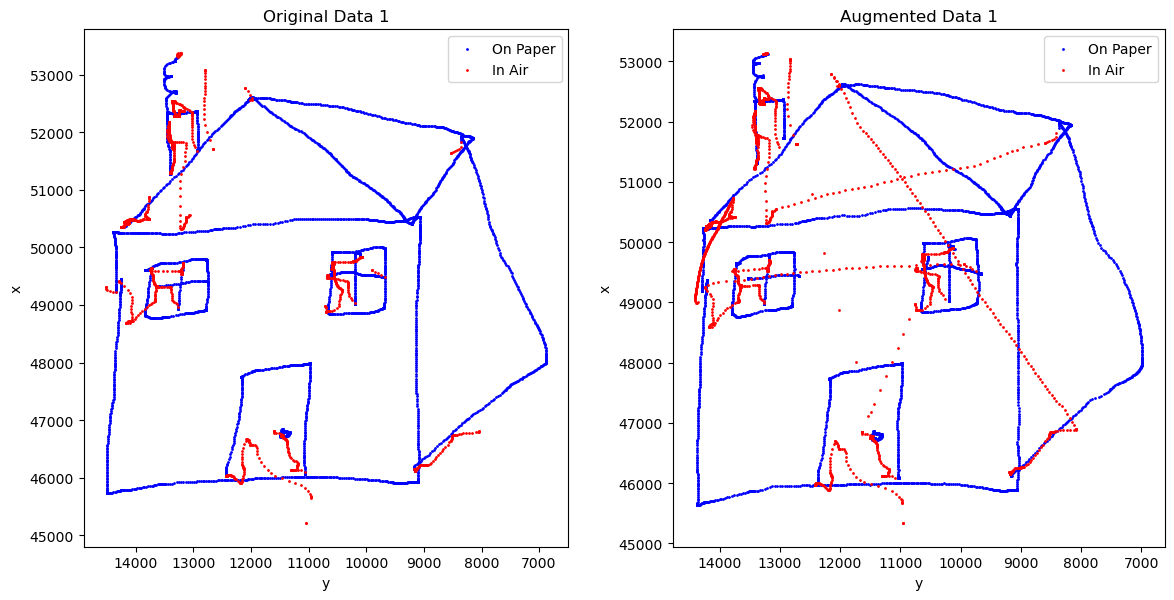

In [44]:
# Cell 9: Plot the original data before imputation using original_data_frames from Cell 2, rotated 90 degrees to the left

# Load the pretrained VAE model
with custom_object_scope({'VAE': VAE}):
    vae_pretrained = load_model('vae_models/epoch_200_model.h5')
print("Pretrained VAE model loaded.")

# Base latent variability settings
base_latent_variability = 100.0
latent_variability_range = (0.99, 1.01)
num_augmented_files = 1

# Generate augmented data using the pretrained model
augmented_datasets = generate_augmented_data(vae_pretrained, num_augmented_files, avg_data_points, processed_data, 
                                             base_latent_variability, latent_variability_range)

# Calculate actual latent variabilities and lengths used
latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
augmented_lengths = [len(data) for data in augmented_datasets]

# Function to visualize augmented data after inverse scaling
def repeat_backwards(original_paa, augmented_length):
    # Calculate how many rows need to be filled
    repeat_count = augmented_length - len(original_paa)

    # If no rows need to be filled, return the original data
    if repeat_count <= 0:
        return original_paa

    # Repeat the original data backwards row by row
    backwards_rows = np.empty((0, original_paa.shape[1]))
    for i in range(repeat_count):
        row_to_repeat = original_paa[-(i + 1)]  # Get the i-th row from the end
        backwards_rows = np.vstack((backwards_rows, row_to_repeat))

    # Append the backward-repeated rows to the original data
    return np.vstack((original_paa, backwards_rows))

# Updated visualization function with the new filling method
def visualize_augmented_data(augmented_datasets, scalers, original_data_frames, axs):
    all_augmented_data = []  # List to store augmented datasets after scaling back

    for i, (augmented_data, scaler, original_df) in enumerate(zip(augmented_datasets, scalers, original_data_frames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data from original data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        # If augmented data is longer, fill the original data by repeating values backwards
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Combine all data
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))
        
        # Store the augmented data for later use
        all_augmented_data.append(augmented_data_original_scale)
        
        # Visualization of the augmented data (after inverse scaling)
        augmented_on_paper = augmented_data_original_scale[augmented_data_original_scale[:, 3] == 1]
        augmented_in_air = augmented_data_original_scale[augmented_data_original_scale[:, 3] == 0]

        # Scatter plot for the augmented data, with rotated axes
        axs[i + len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')  # y -> x, x -> y
        axs[i + len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')  # y -> x, x -> y
        axs[i + len(original_data_frames)].set_title(f'Augmented Data {i + 1}')
        axs[i + len(original_data_frames)].set_xlabel('y')  # Previously 'x'
        axs[i + len(original_data_frames)].set_ylabel('x')  # Previously 'y'
        axs[i + len(original_data_frames)].set_aspect('equal')
        axs[i + len(original_data_frames)].invert_xaxis()  # Flip the horizontal axis (y-axis)
        axs[i + len(original_data_frames)].legend()

    return all_augmented_data  # Return the list of augmented datasets after scaling back


# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6 * (num_augmented_files + len(original_data_frames)), 6))

# Plot the original data before imputation, with a 90-degree left rotation and horizontal flip
for i, original_data in enumerate(original_data_frames):  # Use original_data_frames for raw data visualization
    original_on_paper = original_data[original_data['pen_status'] == 1]
    original_in_air = original_data[original_data['pen_status'] == 0]
    
    # Scatter plot for the original data (before imputation), with rotated axes
    axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')  # y -> x, x -> y
    axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')  # y -> x, x -> y
    axs[i].set_title(f'Original Data {i + 1}')
    axs[i].set_xlabel('y')  # Previously 'x'
    axs[i].set_ylabel('x')  # Previously 'y'
    axs[i].set_aspect('equal')
    axs[i].legend()
    
    # Flip the horizontal axis (y-axis)
    axs[i].invert_xaxis()  # This reverses the 'y' axis to flip the plot horizontally

# Set consistent axis limits for square aspect ratio for both original and augmented data
x_min = min(data['x'].min() for data in original_data_frames)
x_max = max(data['x'].max() for data in original_data_frames)
y_min = min(data['y'].min() for data in original_data_frames)
y_max = max(data['y'].max() for data in original_data_frames)

# Plot the augmented data with the same 90-degree left rotation and horizontal flip
all_augmented_data = visualize_augmented_data(augmented_datasets, scalers, original_data_frames, axs)

plt.tight_layout()
plt.show()

In [20]:
import os
import numpy as np


# Cell 10 (modified to adjust timestamp)


def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Generate new timestamps: start at 0, alternately incrementing by 7 and 8
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]  # Alternate between 7 and 8

        # Replace the timestamp in the 3rd column of augmented_xyz_int
        augmented_xyz_int[:, 2] = new_timestamps

        # Combine all data: XYZ, pen status, pressure, azimuth, altitude
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")


Augmented data saved to augmented_data\augmented_u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5971, 7)
Shapes of augmented datasets:
Shape of augmented dataset 1: (5971, 7)
Shape of augmented dataset 2: (5971, 7)
Shape of augmented dataset 3: (5971, 7)


In [21]:
# Cell 11 NRMSE
def calculate_nrmse(original, predicted):

    if original.shape != predicted.shape:
        raise ValueError("The shapes of the original and predicted datasets must match.")
    
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(original) - np.min(original))
    
    return nrmse

# Example usage:
nrmse_values = []

# Using all_augmented_data from Cell 9
for i, (original, augmented) in enumerate(zip(data_frames, all_augmented_data)):
    original_array = original[['x', 'y', 'timestamp', 'pen_status']].values
    augmented_array = augmented[:, :4]  # Assuming first 4 columns match original data structure

    nrmse = calculate_nrmse(original_array, augmented_array)
    nrmse_values.append(nrmse)

# Print results
for i, nrmse in enumerate(nrmse_values):
    print(f"NRMSE for dataset {i+1}: {nrmse:.4f}")

# Calculate average NRMSE
average_nrmse = np.mean(nrmse_values)
print(f"Average NRMSE: {average_nrmse:.4f}")

NRMSE for dataset 1: 0.0033
Average NRMSE: 0.0033


In [101]:
# Cell 12 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    # Determine the number of features to use (minimum of real and synthetic data)
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    
    # Trim the features to match
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape the data for LSTM input (samples, timesteps, features)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        model.fit(X_train, y_train, epochs=3, batch_size=256, verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    return mean_accuracy, std_accuracy

# Assuming 'processed_data' contains the real data and 'augmented_datasets' contains the synthetic data
real_data = np.concatenate(processed_data, axis=0)
synthetic_data = np.concatenate(augmented_datasets, axis=0)

print(f"Real data shape: {real_data.shape}")
print(f"Synthetic data shape: {synthetic_data.shape}")

mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"\nPost-Hoc Discriminative Score Results:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Interpret the results
if abs(mean_accuracy - 0.5) < 0.05:
    print("\nThe synthetic data is effectively indistinguishable from real data.")
elif mean_accuracy > 0.55:
    print("\nThe classifier can distinguish between real and synthetic data with some accuracy.")
    print("This suggests that the synthetic data may not fully capture all characteristics of the real data.")
else:
    print("\nThe classifier performs worse than random guessing.")
    print("This might indicate issues with the classification process or highly varied data.")

Real data shape: (134924, 4)
Synthetic data shape: (134924, 7)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5027 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5032 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5032 - loss: 0.6929
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.4996 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5007 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5015 - loss: 0.6930
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.5002 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.5023 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.5030 - loss: 0.6929
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.5024 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5016 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5044 - loss: 0.6929
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Epoch 1/3


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.4993 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5003 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5035 - loss: 0.6929
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5014 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5023 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5038 - loss: 0.6928
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.5016 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5029 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.5015 - loss: 0.6930
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4990 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5003 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5029 - loss: 0.6928
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Epoch 1/3


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


949/949 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.5009 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5019 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5055 - loss: 0.6927
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 36s 17ms/step - accuracy: 0.4982 - loss: 0.6932
Epoch 2/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5034 - loss: 0.6931
Epoch 3/3
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5040 - loss: 0.6929
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step

Post-Hoc Discriminative Score Results:
Mean Accuracy: 0.5006
Standard Deviation: 0.0053

The synthetic data is effectively indistinguishable from real data.


In [39]:
# Cell 13 Post Hoc Predictive Score
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from keras.callbacks import Callback
from tqdm import tqdm

# Step 1: Prepare Data
def prepare_data(df, time_steps=5):
    data = df[['x', 'y']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences of length `time_steps`
    X, y = [], []
    for i in range(len(data_scaled) - time_steps):
        X.append(data_scaled[i:i+time_steps])
        y.append(data_scaled[i+time_steps])
    
    return np.array(X), np.array(y), scaler

# Example usage
X, y, scaler = prepare_data(data_frames[0])

# Custom callback for progress bar
class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc="Training Progress")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Step 2: Define the LSTM Model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Adding dropout to introduce randomness
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(2))  # Predict x and y
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 3: Evaluate Model Function
def evaluate_model(model, X_test, y_test, scaler):
    # Predict and inverse transform
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Compute MAPE for each test sample
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
    print(f"\nMAPE: {mape * 100:.2f}%")
    
    # Interpretation of MAPE
    if mape < 0.1:
        interpretation = "Excellent prediction"
    elif mape < 0.2:
        interpretation = "Good prediction"
    elif mape < 0.5:
        interpretation = "Fair prediction"
    else:
        interpretation = "Poor prediction"
    
    print(f"Interpretation: {interpretation}")
    
    return mape

# Step 4: K-Fold Cross-Validation Implementation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.randint(1000))  # 10-fold cross-validation

mape_values = []
for train_index, test_index in kf.split(X):
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    refactor: compile functions in scbetavaegan.py

    model = create_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=5, batch_size=512, verbose=0, callbacks=[CustomCallback()])
    
    # Evaluate the model and store MAPE
    mape = evaluate_model(model, X_test, y_test, scaler)
    mape_values.append(mape)

# Step 5: Calculate Mean and Standard Deviation of MAPE
mean_mape = np.mean(mape_values)
std_mape = np.std(mape_values)

print(f"\nMean MAPE: {mean_mape * 100:.2f}%")
print(f"Standard Deviation of MAPE: {std_mape * 100:.2f}%")


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 21s - 3s/step - loss: 0.2534
Epoch 2/5
7/7 - 2s - 221ms/step - loss: 0.1136
Epoch 3/5
7/7 - 2s - 259ms/step - loss: 0.0542
Epoch 4/5
7/7 - 3s - 358ms/step - loss: 0.0412
Epoch 5/5
7/7 - 2s - 234ms/step - loss: 0.0192
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step

MAPE: 1.37%
Interpretation: Excellent prediction


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 16s - 2s/step - loss: 0.3178
Epoch 2/5
7/7 - 1s - 166ms/step - loss: 0.1833
Epoch 3/5
7/7 - 2s - 233ms/step - loss: 0.0695
Epoch 4/5
7/7 - 1s - 210ms/step - loss: 0.0515
Epoch 5/5
7/7 - 2s - 240ms/step - loss: 0.0283
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step

MAPE: 1.61%
Interpretation: Excellent prediction


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 16s - 2s/step - loss: 0.2801
Epoch 2/5
7/7 - 1s - 96ms/step - loss: 0.1322
Epoch 3/5
7/7 - 1s - 134ms/step - loss: 0.0518
Epoch 4/5
7/7 - 1s - 113ms/step - loss: 0.0426
Epoch 5/5
7/7 - 1s - 134ms/step - loss: 0.0189
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step

MAPE: 1.30%
Interpretation: Excellent prediction


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 18s - 3s/step - loss: 0.3207
Epoch 2/5
7/7 - 2s - 225ms/step - loss: 0.1762
Epoch 3/5
7/7 - 4s - 534ms/step - loss: 0.0733
Epoch 4/5
7/7 - 4s - 600ms/step - loss: 0.0428
Epoch 5/5
7/7 - 2s - 270ms/step - loss: 0.0303
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step

MAPE: 1.32%
Interpretation: Excellent prediction


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 22s - 3s/step - loss: 0.3032
Epoch 2/5
7/7 - 2s - 283ms/step - loss: 0.1579
Epoch 3/5
7/7 - 1s - 150ms/step - loss: 0.0579
Epoch 4/5
7/7 - 1s - 147ms/step - loss: 0.0495
Epoch 5/5
7/7 - 2s - 307ms/step - loss: 0.0240
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step

MAPE: 1.48%
Interpretation: Excellent prediction


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 17s - 2s/step - loss: 0.2951
Epoch 2/5
7/7 - 1s - 117ms/step - loss: 0.1413
Epoch 3/5
7/7 - 1s - 168ms/step - loss: 0.0536
Epoch 4/5
7/7 - 2s - 262ms/step - loss: 0.0454
Epoch 5/5
7/7 - 1s - 189ms/step - loss: 0.0220
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step

MAPE: 1.47%
Interpretation: Excellent prediction


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 14s - 2s/step - loss: 0.2709
Epoch 2/5
7/7 - 1s - 134ms/step - loss: 0.1234
Epoch 3/5
7/7 - 1s - 132ms/step - loss: 0.0613
Epoch 4/5
7/7 - 2s - 297ms/step - loss: 0.0483
Epoch 5/5
7/7 - 1s - 110ms/step - loss: 0.0283
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step

MAPE: 1.58%
Interpretation: Excellent prediction


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 19s - 3s/step - loss: 0.2786
Epoch 2/5
7/7 - 2s - 290ms/step - loss: 0.1288
Epoch 3/5
7/7 - 1s - 195ms/step - loss: 0.0499
Epoch 4/5
7/7 - 2s - 246ms/step - loss: 0.0446
Epoch 5/5
7/7 - 1s - 205ms/step - loss: 0.0208
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step

MAPE: 1.41%
Interpretation: Excellent prediction


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 14s - 2s/step - loss: 0.2787
Epoch 2/5
7/7 - 1s - 110ms/step - loss: 0.1199
Epoch 3/5
7/7 - 1s - 136ms/step - loss: 0.0511
Epoch 4/5
7/7 - 1s - 113ms/step - loss: 0.0391
Epoch 5/5
7/7 - 1s - 143ms/step - loss: 0.0170
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step

MAPE: 1.34%
Interpretation: Excellent prediction


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7/7 - 14s - 2s/step - loss: 0.2513
Epoch 2/5
7/7 - 1s - 127ms/step - loss: 0.1099
Epoch 3/5
7/7 - 1s - 126ms/step - loss: 0.0507
Epoch 4/5
7/7 - 1s - 111ms/step - loss: 0.0351
Epoch 5/5
7/7 - 1s - 116ms/step - loss: 0.0163
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step

MAPE: 1.28%
Interpretation: Excellent prediction

Mean MAPE: 1.42%
Standard Deviation of MAPE: 0.11%


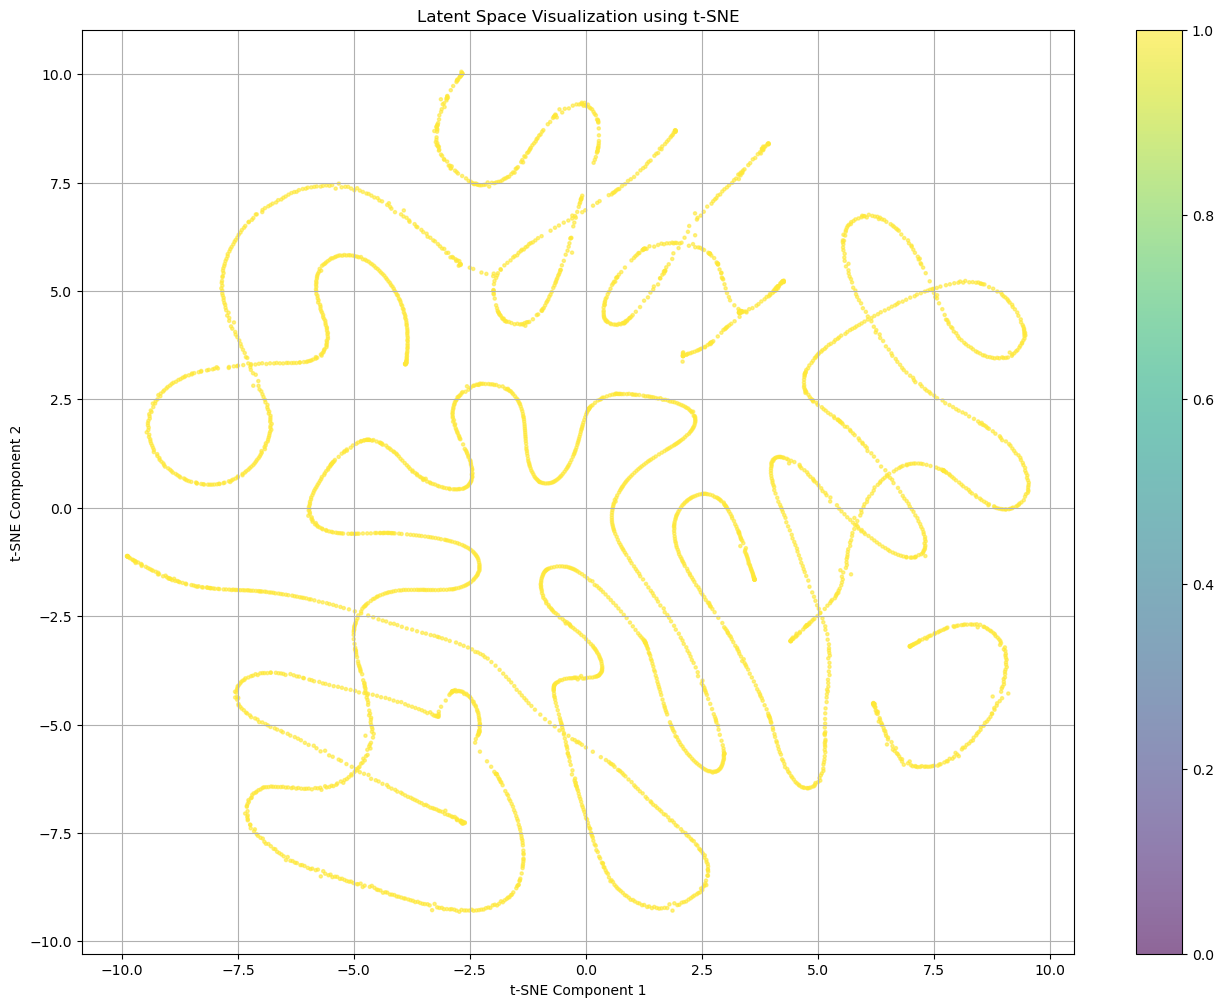

In [109]:
#Cell 13 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])